In [1]:
# Q sensitivity to P/T
# CTSM simulation vs CAMELS Obs

# Reference:
# Lehner, F., Wood, A. W., Vano, J. A., Lawrence, D. M., Clark, M. P., & Mankin, J. S. (2019).
# The potential to reduce uncertainty in regional runoff projections from climate models.
# Nature Climate Change, 9(12), 926–933. https://doi.org/10.1038/s41558-019-0639-x


import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from shapely.geometry import Polygon, box
import geopandas as gpd
import os, scipy
import warnings
warnings.filterwarnings('ignore')

# Load data

In [2]:
infile_info = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(infile_info)

In [3]:
# Defa + Obs sensitivity
df_defa = []
for i in range(len(df_info)):
    filei = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/Defa/level1_{i}/Q_sensitivity_nocalib.csv'
    dfi = pd.read_csv(filei)
    dfi['basin'] = i
    df_defa.append(dfi)

df_defa = pd.concat(df_defa)

In [4]:
# Optmz + Obs sensitivity
df_optm = []
for i in range(len(df_info)):
    filei = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_{i}/normKGEr1/Q_sensitivity_nocalib.csv'
    if os.path.isfile(filei):
        dfi = pd.read_csv(filei)
    else:
        dfi = dfi.copy()
        dfi['Obs']=np.nan
        dfi['Simu']=np.nan
        print('Missing:', filei)
    dfi['basin'] = i
    df_optm.append(dfi)

df_optm = pd.concat(df_optm)

Missing: /glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/LongTermSimu/LSEallbasin/level1_329/normKGEr1/Q_sensitivity_nocalib.csv


In [5]:
# check whether they are consistent for obs
diff = np.abs(df_optm['Obs'].values - df_defa['Obs'].values)
if np.nanmax(diff)>1e-3:
    print('Warning! Different Obs')
    print( np.nanmax(diff))
else:
    print('Consistent Obs')

Consistent Obs


In [6]:
# assign variables

obs_dQ_v_dT = df_defa[df_defa['senst']=='T']['Obs'].values
obs_dQ_v_dP = df_defa[df_defa['senst']=='P']['Obs'].values
obs_dQ_v_dPdT = df_defa[df_defa['senst']=='PT']['Obs'].values

obs_dQ_v_dT_range = np.vstack( [df_defa[df_defa['senst']=='Tlow']['Obs'].values, df_defa[df_defa['senst']=='Tup']['Obs'].values]).T
obs_dQ_v_dP_range = np.vstack( [df_defa[df_defa['senst']=='Plow']['Obs'].values, df_defa[df_defa['senst']=='Pup']['Obs'].values]).T
obs_dQ_v_dPdT_range = np.vstack( [df_defa[df_defa['senst']=='PTlow']['Obs'].values, df_defa[df_defa['senst']=='PTup']['Obs'].values]).T


sim_defa_dQ_v_dT = df_defa[df_defa['senst']=='T']['Simu'].values
sim_defa_dQ_v_dP = df_defa[df_defa['senst']=='P']['Simu'].values
sim_defa_dQ_v_dPdT = df_defa[df_defa['senst']=='PT']['Simu'].values

sim_defa_dQ_v_dT_range = np.vstack( [df_defa[df_defa['senst']=='Tlow']['Simu'].values, df_defa[df_defa['senst']=='Tup']['Simu'].values]).T
sim_defa_dQ_v_dP_range = np.vstack( [df_defa[df_defa['senst']=='Plow']['Simu'].values, df_defa[df_defa['senst']=='Pup']['Simu'].values]).T
sim_defa_dQ_v_dPdT_range = np.vstack( [df_defa[df_defa['senst']=='PTlow']['Simu'].values, df_defa[df_defa['senst']=='PTup']['Simu'].values]).T

sim_optm_dQ_v_dT = df_optm[df_optm['senst']=='T']['Simu'].values
sim_optm_dQ_v_dP = df_optm[df_optm['senst']=='P']['Simu'].values
sim_optm_dQ_v_dPdT = df_optm[df_optm['senst']=='PT']['Simu'].values

sim_optm_dQ_v_dT_range = np.vstack( [df_optm[df_optm['senst']=='Tlow']['Simu'].values, df_optm[df_optm['senst']=='Tup']['Simu'].values]).T
sim_optm_dQ_v_dP_range = np.vstack( [df_optm[df_optm['senst']=='Plow']['Simu'].values, df_optm[df_optm['senst']=='Pup']['Simu'].values]).T
sim_optm_dQ_v_dPdT_range = np.vstack( [df_optm[df_optm['senst']=='PTlow']['Simu'].values, df_optm[df_optm['senst']=='PTup']['Simu'].values]).T


# Plot sensitivities

## Plot spatial maps

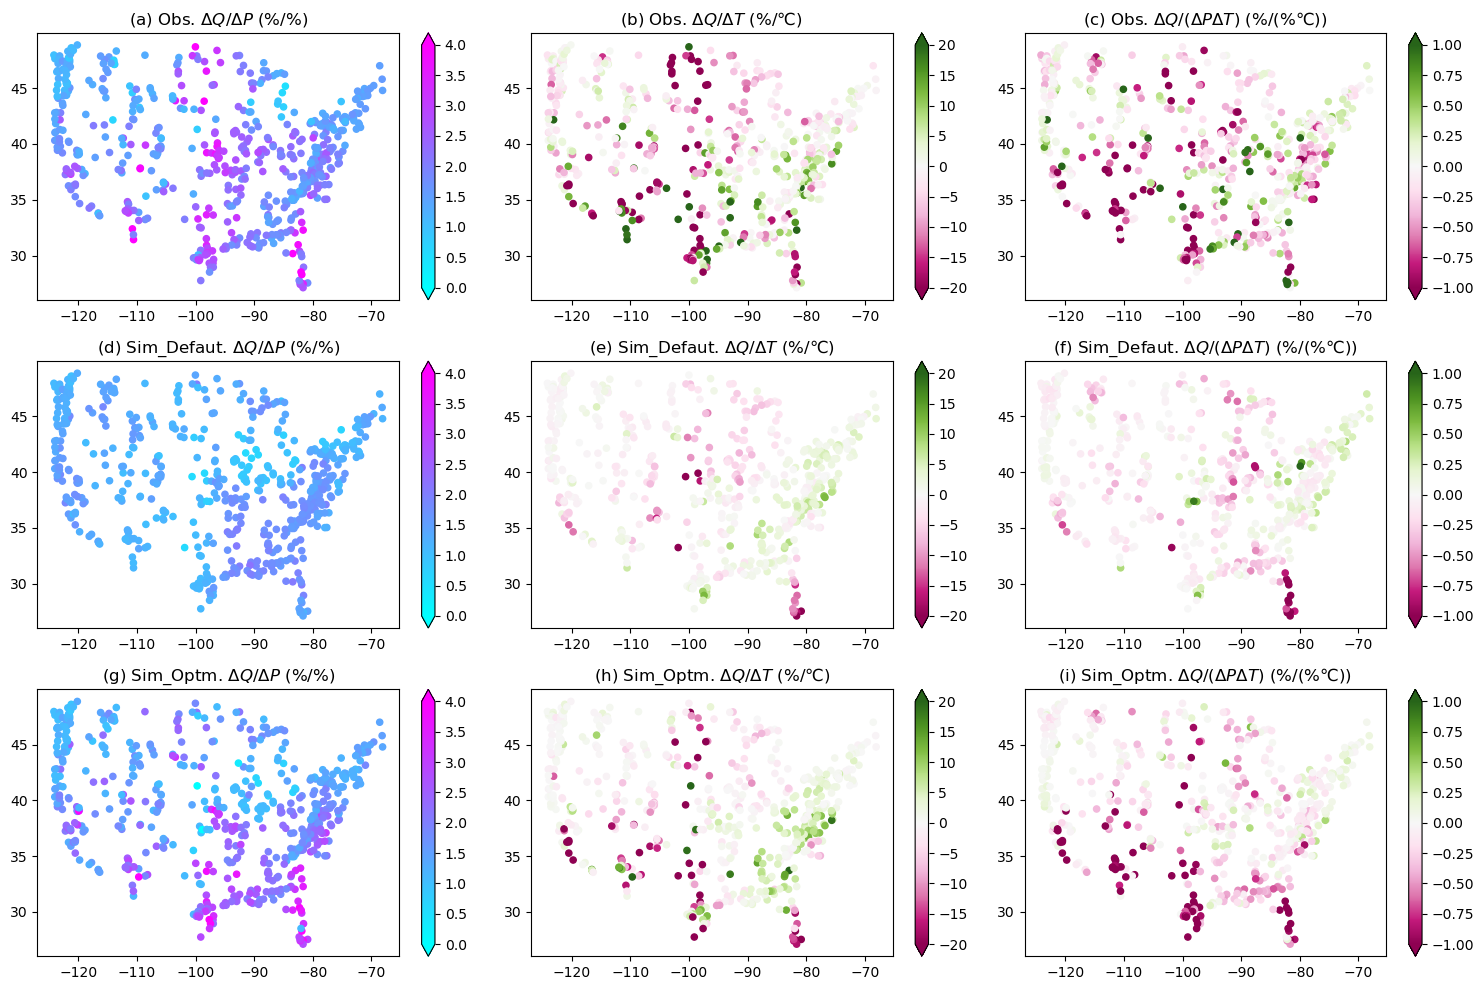

In [7]:
# spatial map

dataplot = [ [obs_dQ_v_dP, obs_dQ_v_dT, obs_dQ_v_dPdT], 
             [sim_defa_dQ_v_dP, sim_defa_dQ_v_dT, sim_defa_dQ_v_dPdT], 
             [sim_optm_dQ_v_dP, sim_optm_dQ_v_dT, sim_optm_dQ_v_dPdT], 
             ]

vminvmax = [ [[0, 4], [-20, 20], [-1, 1]], 
             [[0, 4], [-20, 20], [-1, 1]],
             [[0, 4], [-20, 20], [-1, 1]] ] 
cmaps = [ ['cool', 'PiYG', 'PiYG'], 
          ['cool', 'PiYG', 'PiYG'],
          ['cool', 'PiYG', 'PiYG'] ]
 

lat = df_info['lat_cen'].values
lon = df_info['lon_cen'].values
titles = [ [r"(a) Obs. $\Delta Q /\Delta P$ (%/%)", r"(b) Obs. $\Delta Q /\Delta T$ (%/℃)", r"(c) Obs. $\Delta Q /(\Delta P \Delta T)$ (%/(%℃))"], 
           [r"(d) Sim_Defaut. $\Delta Q /\Delta P$ (%/%)", r"(e) Sim_Defaut. $\Delta Q /\Delta T$ (%/℃)", r"(f) Sim_Defaut. $\Delta Q /(\Delta P \Delta T)$ (%/(%℃))"],
          [r"(g) Sim_Optm. $\Delta Q /\Delta P$ (%/%)", r"(h) Sim_Optm. $\Delta Q /\Delta T$ (%/℃)", r"(i) Sim_Optm. $\Delta Q /(\Delta P \Delta T)$ (%/(%℃))"] ]

fig, axs = plt.subplots(3, 3, figsize=[15, 10])

for i in range(3):
    for j in range(3):
        ax = axs[i, j]
        
        p = ax.scatter(lon, lat, 20, dataplot[i][j], cmap=cmaps[i][j], vmin=vminvmax[i][j][0], vmax=vminvmax[i][j][1])
        ax.set_title(titles[i][j])

        plt.colorbar(p, ax=ax, extend='both')
        
        # Upper colorado
#         ax.set_ylim([37, 41])
#         ax.set_xlim([-109, -102])
        
    
plt.tight_layout()
# plt.show()
plt.savefig('Sensitivity_map.png', dpi=600, facecolor='w', bbox_inches='tight',pad_inches = 0)


## Plot confidence invervobs_dQ_v_dPals
Note basins are sorted from low to high sensitivities. Sim and Obs are sorted separately. 

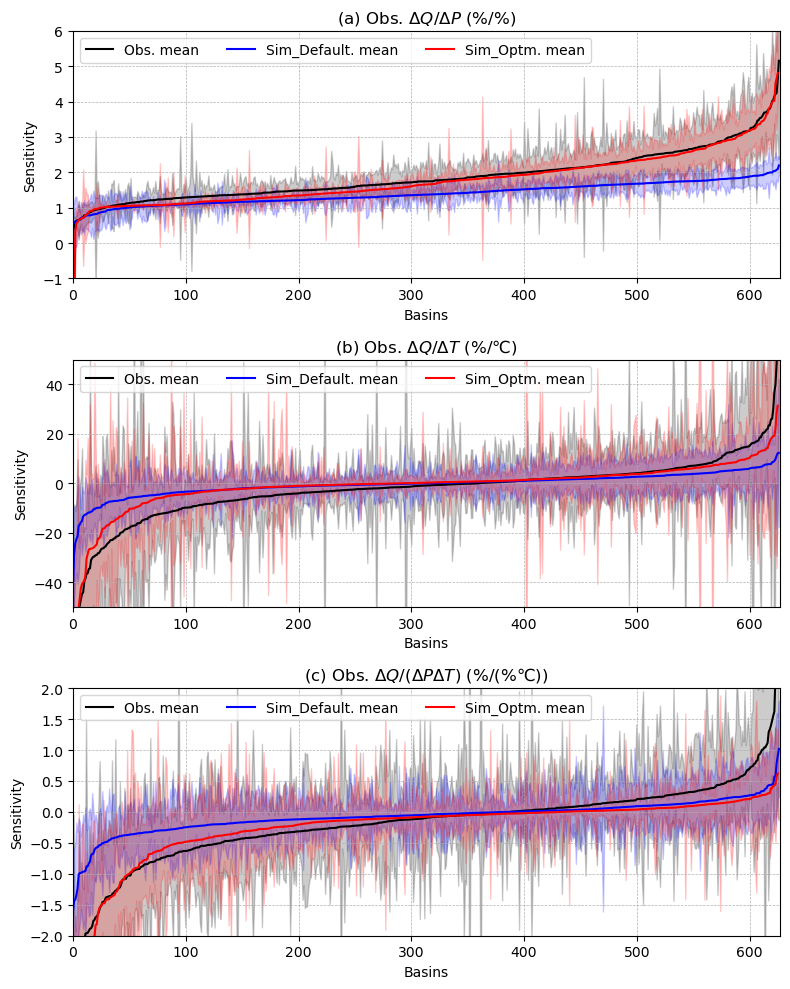

In [8]:
# curve: type-2, obs and sim in same figure

dataplot = [ [obs_dQ_v_dP, obs_dQ_v_dT, obs_dQ_v_dPdT], 
             [sim_defa_dQ_v_dP, sim_defa_dQ_v_dT, sim_defa_dQ_v_dPdT], 
             [sim_optm_dQ_v_dP, sim_optm_dQ_v_dT, sim_optm_dQ_v_dPdT], 
             ]

datarangeplot = [ [obs_dQ_v_dP_range, obs_dQ_v_dT_range, obs_dQ_v_dPdT_range], 
             [sim_defa_dQ_v_dP_range, sim_defa_dQ_v_dT_range, sim_defa_dQ_v_dPdT_range], 
             [sim_optm_dQ_v_dP_range, sim_optm_dQ_v_dT_range, sim_optm_dQ_v_dPdT_range], 
             ]


vminvmax = [ [[-1, 6], [-50, 50], [-2, 2]], 
             [[-1, 6], [-50, 50], [-2, 2]] ] 


fig, axs = plt.subplots(3, 1, figsize=[8, 10])

for i in range(3):
    for j in range(1):
        ax = axs[i]
        
        #obs
        data = dataplot[0][i]
        data_range = datarangeplot[0][i]

        sorted_indices = np.argsort(data)
        sorted_data = data[sorted_indices]
        sorted_data_range = data_range[sorted_indices]

        ax.plot(range(len(sorted_data)), sorted_data, label="Obs. mean", color='black')
        ax.fill_between(range(len(sorted_data)), 
                         sorted_data_range[:, 0], 
                         sorted_data_range[:, 1], 
                         color='black', alpha=0.2) #, label="Obs. 5-95%")
        
        #sim default
        data = dataplot[1][i]
        data_range = datarangeplot[1][i]

        sorted_indices = np.argsort(data)
        sorted_data = data[sorted_indices]
        sorted_data_range = data_range[sorted_indices]

        ax.plot(range(len(sorted_data)), sorted_data, label="Sim_Default. mean", color='blue')
        ax.fill_between(range(len(sorted_data)), 
                         sorted_data_range[:, 0], 
                         sorted_data_range[:, 1], 
                         color='blue', alpha=0.2) #, label="Sim_Default. 5-95%")
        
        #sim optmization
        data = dataplot[2][i]
        data_range = datarangeplot[2][i]

        sorted_indices = np.argsort(data)
        sorted_data = data[sorted_indices]
        sorted_data_range = data_range[sorted_indices]

        ax.plot(range(len(sorted_data)), sorted_data, label="Sim_Optm. mean", color='red')
        ax.fill_between(range(len(sorted_data)), 
                         sorted_data_range[:, 0], 
                         sorted_data_range[:, 1], 
                         color='red', alpha=0.2) #, label="Sim_Optm. 5-95%")

        ax.set_title(titles[0][i])
        ax.set_xlabel("Basins")
        ax.set_ylabel("Sensitivity")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        
        ax.legend(loc='upper left', ncol=4)
        ax.set_ylim(vminvmax[0][i])
        ax.set_xlim(0, len(data))

plt.tight_layout()
# plt.show()
plt.savefig('Sensitivity_CDF.png', dpi=600, facecolor='w', bbox_inches='tight',pad_inches = 0)

## scatter plots

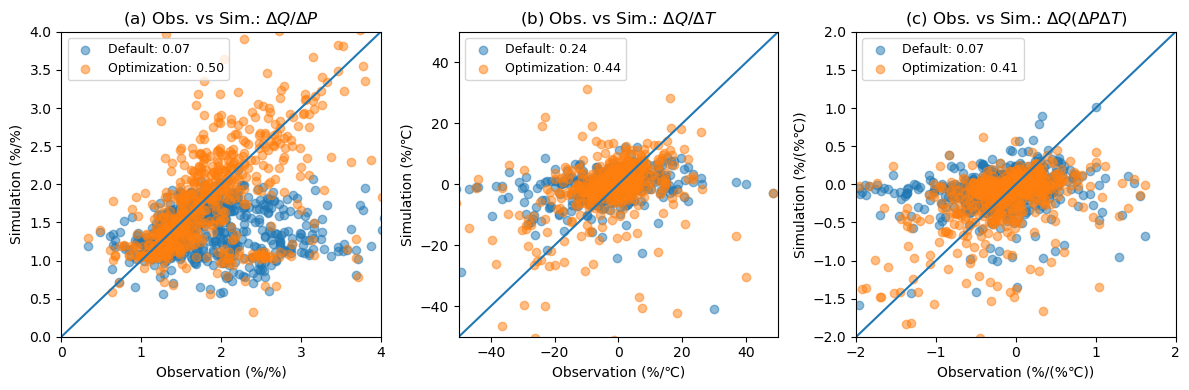

In [9]:
# scatter-1

dataplot = [ [obs_dQ_v_dP, obs_dQ_v_dT, obs_dQ_v_dPdT], 
             [sim_defa_dQ_v_dP, sim_defa_dQ_v_dT, sim_defa_dQ_v_dPdT], 
             [sim_optm_dQ_v_dP, sim_optm_dQ_v_dT, sim_optm_dQ_v_dPdT], 
             ]

vminvmax = [ [0, 4], [-50, 50], [-2, 2] ] 
units = ['(%/%)', '(%/℃)', '(%/(%℃))']


titles = [ r"(a) Obs. vs Sim.: $\Delta Q /\Delta P$", r"(b) Obs. vs Sim.: $\Delta Q /\Delta T$", r"(c) Obs. vs Sim.: $\Delta Q (\Delta P \Delta T)$" ]

fig, axs = plt.subplots(1, 3, figsize=[12, 4])

for i in range(3):
    ax = axs[i]
        
    ax.scatter(dataplot[0][i], dataplot[1][i], alpha=0.5, label='Default')
    
    ax.scatter(dataplot[0][i], dataplot[2][i], alpha=0.5, label='Optimization')
    
    ax.plot(vminvmax[i], vminvmax[i])
    
    ax.set_title(titles[i])
    
    ax.set_xlim(vminvmax[i])
    ax.set_ylim(vminvmax[i])
    
    ax.set_xlabel('Observation '+units[i])
    ax.set_ylabel('Simulation '+units[i])

    ind = ~np.isnan(dataplot[0][i]+dataplot[1][i]+dataplot[2][i])
    cc1 = np.corrcoef(dataplot[0][i][ind], dataplot[1][i][ind])[0,1]
    cc2 = np.corrcoef(dataplot[0][i][ind], dataplot[2][i][ind])[0,1]
    cct = [f'Default: {cc1:.2f}', f'Optimization: {cc2:.2f}']
    
    ax.legend(cct, frameon=True, fontsize=9)
    
    
plt.tight_layout()
# plt.show()
plt.savefig('Sensitivity_scatter.png', dpi=600, facecolor='w', bbox_inches='tight',pad_inches = 0)

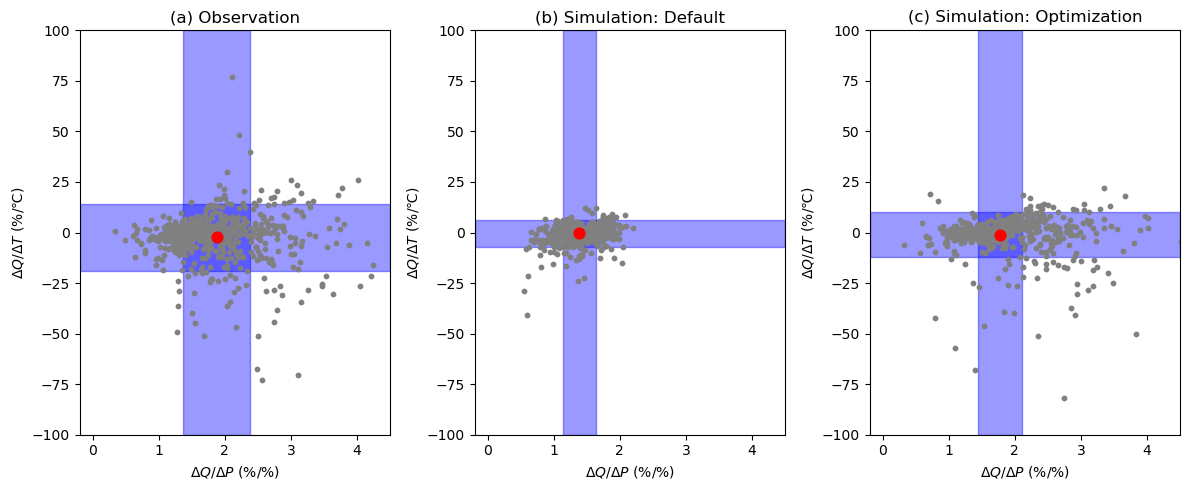

In [10]:
# scatter-2: 
xsc = [obs_dQ_v_dP, sim_defa_dQ_v_dP, sim_optm_dQ_v_dP]
ysc = [obs_dQ_v_dT, sim_defa_dQ_v_dT, sim_optm_dQ_v_dT]
xplot = [np.nanmean(obs_dQ_v_dP), np.nanmean(sim_defa_dQ_v_dP), np.nanmean(sim_optm_dQ_v_dP)]
yplot = [np.nanmean(obs_dQ_v_dT), np.nanmean(sim_defa_dQ_v_dT), np.nanmean(sim_optm_dQ_v_dT)]
xrangeplot = [ np.nanmean(obs_dQ_v_dP_range, axis=0),  np.nanmean(sim_defa_dQ_v_dP_range, axis=0),  np.nanmean(sim_optm_dQ_v_dP_range, axis=0)]
yrangeplot = [ np.nanmean(obs_dQ_v_dT_range, axis=0), np.nanmean(sim_defa_dQ_v_dT_range, axis=0), np.nanmean(sim_optm_dQ_v_dT_range, axis=0) ]

titles = ['(a) Observation', '(b) Simulation: Default', '(c) Simulation: Optimization']

xlim = [-0.2, 4.5]
ylim = [-100, 100]

fig, axs = plt.subplots(1, 3, figsize=[12, 5])

for i in range(3):
    ax = axs[i]
    
    # plt.fill_between(xrange, [yrange[0], yrange[0]], [yrange[1], yrange[1]], color='b', alpha=0.4)
    ax.fill_between(xrangeplot[i], [ylim[0], ylim[0]], [ylim[1], ylim[1]], color='b', alpha=0.4)
    ax.fill_between(xlim, [yrangeplot[i][0], yrangeplot[i][0]], [yrangeplot[i][1], yrangeplot[i][1]], color='b', alpha=0.4)
    ax.scatter(xsc[i], ysc[i], 10, color='grey')
    ax.scatter(xplot[i], yplot[i], 60, color='r')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel(r"$\Delta Q /\Delta T $ (%/℃)")
    ax.set_xlabel(r"$\Delta Q /\Delta P$ (%/%)")
    ax.set_title(titles[i])

plt.tight_layout()
# plt.show()
plt.savefig('Sensitivity_scatter2.png', dpi=600, facecolor='w', bbox_inches='tight',pad_inches = 0)